In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Load data

In [42]:
data = pd.read_csv('../preprocessing/datasets/tesla_apple_stock_price.csv', index_col=0)
data.head()

,Apple,Tesla,bond_rate,Dow,tech_index,health_index,consumer_dis_index,consumer_staples_index,energy_index,financial_index,...,real_estate_index,utilities_index,JPYUSD,CNYUSD,EURUSD,date,country,month,log_apple,log_tesla
8782,24.848475,15.114667,1.398,17050.750000,37.280865,59.642284,70.730659,39.916458,49.383343,16.221687,...,22.927450,33.919144,0.008339,0.157577,1.124000,2015-10-08,US,10,3.212796,2.715666
8783,25.443027,14.712667,1.406,17084.490234,37.443348,59.913666,70.812683,40.005421,49.063103,16.117661,...,22.889507,33.757278,0.008338,0.157642,1.128694,2015-10-09,US,10,3.236442,2.688709
8784,25.325024,14.372000,1.400,17131.859375,37.488480,60.071239,71.149803,40.110588,48.429699,16.131527,...,23.033701,34.057907,0.008321,0.157846,1.136997,2015-10-12,US,10,3.231793,2.665282
8785,25.368139,14.616667,1.362,17081.890625,37.407238,59.318375,70.767113,39.867928,47.924412,16.006695,...,22.889507,33.980831,0.008333,0.158403,1.135551,2015-10-13,US,10,3.233494,2.682162
8786,25.009598,14.458667,1.280,16924.750000,37.335026,59.204567,70.047333,39.406887,48.337158,15.874916,...,22.889507,33.973110,0.008353,0.157920,1.138498,2015-10-14,US,10,3.219260,2.671294


# Common function

In [43]:
# evaluate with MAE, MAPE

def evaluation_mae_mape(y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    metrics = pd.DataFrame({"MAE": [mae], "MAPE": [mape]})
    return metrics

In [44]:
# make dataframe for plotting
def eval_df(y_real, y_pred):
    df = pd.DataFrame()
    df["Target"] = y_real
    df["Pred"] = y_pred
    return df

In [45]:
# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

In [46]:
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

In [47]:
# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

# ML regression Model

Use simple machine learinng regression with rolling window - 20 days (1 month), 60 days (3 month), 252 days (1 year)
- Extract rolling window datasets
- Fit regression model and get co-efficient
- Predict with model

In [48]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("stock prediction")

mlflow.sklearn.autolog()

## 60 days datasets

- target : Apple price

- variables : 60 days variabels (60 x 16) 

In [49]:
df = data.set_index('date')
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1995 entries, 2015-10-08 to 2023-09-20
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Apple                   1995 non-null   float64
 1   Tesla                   1995 non-null   float64
 2   bond_rate               1995 non-null   float64
 3   Dow                     1995 non-null   float64
 4   tech_index              1995 non-null   float64
 5   health_index            1995 non-null   float64
 6   consumer_dis_index      1995 non-null   float64
 7   consumer_staples_index  1995 non-null   float64
 8   energy_index            1995 non-null   float64
 9   financial_index         1995 non-null   float64
 10  industrial_index        1995 non-null   float64
 11  material_index          1995 non-null   float64
 12  real_estate_index       1995 non-null   float64
 13  utilities_index         1995 non-null   float64
 14  JPYUSD                

In [50]:
target = df[['Apple']]
target

,Apple
date,
2015-10-08,24.848475
2015-10-09,25.443027
2015-10-12,25.325024
2015-10-13,25.368139
2015-10-14,25.009598
...,...
2023-09-14,175.740005
2023-09-15,175.009995
2023-09-18,177.970001


In [51]:
df = df.drop(['Apple', 'Tesla', 'country', 'log_apple', 'log_tesla'], axis=1)

In [52]:
df.head()

,bond_rate,Dow,tech_index,health_index,consumer_dis_index,consumer_staples_index,energy_index,financial_index,industrial_index,material_index,real_estate_index,utilities_index,JPYUSD,CNYUSD,EURUSD,month
date,,,,,,,,,,,,,,,,
2015-10-08,1.398,17050.750000,37.280865,59.642284,70.730659,39.916458,49.383343,16.221687,45.808945,37.534855,22.927450,33.919144,0.008339,0.157577,1.124000,10
2015-10-09,1.406,17084.490234,37.443348,59.913666,70.812683,40.005421,49.063103,16.117661,45.963940,37.517872,22.889507,33.757278,0.008338,0.157642,1.128694,10
2015-10-12,1.400,17131.859375,37.488480,60.071239,71.149803,40.110588,48.429699,16.131527,45.972557,37.194946,23.033701,34.057907,0.008321,0.157846,1.136997,10
2015-10-13,1.362,17081.890625,37.407238,59.318375,70.767113,39.867928,47.924412,16.006695,45.481747,37.050476,22.889507,33.980831,0.008333,0.158403,1.135551,10
2015-10-14,1.280,16924.750000,37.335026,59.204567,70.047333,39.406887,48.337158,15.874916,44.990925,37.347916,22.889507,33.973110,0.008353,0.157920,1.138498,10


In [53]:
y = target[61:]
y

,Apple
date,
2016-01-06,22.949333
2016-01-07,21.980772
2016-01-08,22.097004
2016-01-11,22.454798
2016-01-12,22.780691
...,...
2023-09-14,175.740005
2023-09-15,175.009995
2023-09-18,177.970001


In [54]:
window = 60
test = np.array(df.iloc[0:window, :])
test = np.stack([test, df.iloc[0+1:window+1, :]])
test


array([[[1.39800000e+00, 1.70507500e+04, 3.72808647e+01, ...,
         1.57577097e-01, 1.12399960e+00, 1.00000000e+01],
        [1.40600002e+00, 1.70844902e+04, 3.74433479e+01, ...,
         1.57641679e-01, 1.12869358e+00, 1.00000000e+01],
        [1.39999998e+00, 1.71318594e+04, 3.74884796e+01, ...,
         1.57845721e-01, 1.13699675e+00, 1.00000000e+01],
        ...,
        [1.79900002e+00, 1.76038691e+04, 3.94095612e+01, ...,
         1.54444918e-01, 1.09280062e+00, 1.20000000e+01],
        [1.75800002e+00, 1.74250293e+04, 3.88561668e+01, ...,
         1.54292405e-01, 1.09339809e+00, 1.20000000e+01],
        [1.73500001e+00, 1.71489395e+04, 3.83481293e+01, ...,
         1.54232934e-01, 1.08539915e+00, 1.00000000e+00]],

       [[1.40600002e+00, 1.70844902e+04, 3.74433479e+01, ...,
         1.57641679e-01, 1.12869358e+00, 1.00000000e+01],
        [1.39999998e+00, 1.71318594e+04, 3.74884796e+01, ...,
         1.57845721e-01, 1.13699675e+00, 1.00000000e+01],
        [1.36199999e+00, 

In [55]:
test.shape

(2, 60, 16)

In [56]:
window = 60

for i in range(1934):
    if i==0:
        x0 = np.array(df.iloc[0+i:window+i, :])
        print(x0.shape)
    elif i==1:
        x1 = np.array(df.iloc[0+i:window+i, :])
        X = np.stack([x0, x1])
        print(X.shape)
    else:
        xn = np.array([df.iloc[0+i:window+i, :]])
        X = np.append(X, xn, axis=0)

X.shape

(60, 16)
(2, 60, 16)


(1934, 60, 16)

## Train and test split

In [57]:
X[-252:].shape

(252, 60, 16)

In [58]:
y.iloc[:252, 0]

date
2016-01-06    22.949333
2016-01-07    21.980772
2016-01-08    22.097004
2016-01-11    22.454798
2016-01-12    22.780691
                ...    
2016-12-30    26.982430
2017-01-03    27.059311
2017-01-04    27.029016
2017-01-05    27.166471
2017-01-06    27.469328
Name: Apple, Length: 252, dtype: float64

In [59]:
X_train, X_test = X[:-252], X[-252:]
y_train, y_test = y.iloc[:-252], y.iloc[-252:]

In [124]:
X_train.shape

(1682, 60, 16)

In [60]:
len(X_train)

1682

In [61]:
len(X_test)

252

In [62]:
# reshape into 2 dimensional matrix
X_train_re = X_train.reshape(1682,-1)
X_test_re = X_test.reshape(252,-1)

In [63]:
print(X_test_re.shape, y_train.shape)

(252, 960) (1682, 1)


## Linear regression

In [64]:
lr = LinearRegression()
lr.fit(X_train_re, y_train)

2023/09/23 10:13:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '89e7bac6f67742d3877df6e964bd0821', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/23 10:13:44 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


LinearRegression()

In [65]:
pred_lr = lr.predict(X_test_re)

In [66]:
graph = pd.DataFrame()
graph["Target"] = y_test
graph["Pred"] = pred_lr
graph

,Target,Pred
date,,
2022-09-20,155.974686,151.446542
2022-09-21,152.813461,157.580399
2022-09-22,151.839249,153.768445
2022-09-23,149.542847,142.942339
2022-09-26,149.880859,138.097029
...,...,...
2023-09-14,175.740005,208.778020
2023-09-15,175.009995,211.031291
2023-09-18,177.970001,212.261071


<Axes: xlabel='date'>

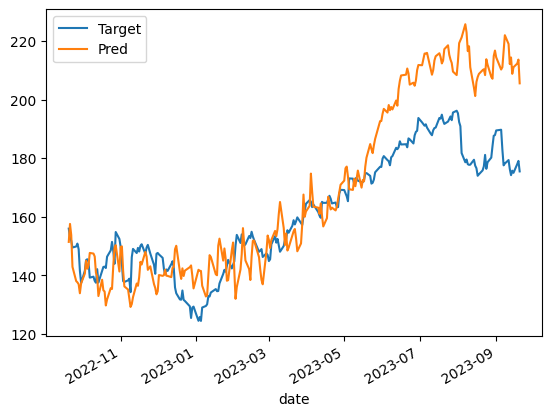

In [67]:
eval_df(y_test, pred_lr).plot()

In [68]:
# mae = mean_absolute_error(y_test, pred)
# mape = mean_absolute_percentage_error(y_test, pred)
# metrics = pd.DataFrame({"MAE": [mae], "MAPE": [mape]})
# metrics

eval_lr = evaluation_mae_mape(y_test, pred_lr)
eval_lr

,MAE,MAPE
0,12.464643,0.074195


## Random Forest

In [69]:
rf = RandomForestRegressor()

rf.fit(X_train_re, y_train)

2023/09/23 10:15:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '03c1089a2fbf420095e8ce8d65a2d02e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/23 10:15:17 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
/Users/woojin/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [70]:
pred_rf = rf.predict(X_test_re)

<Axes: xlabel='date'>

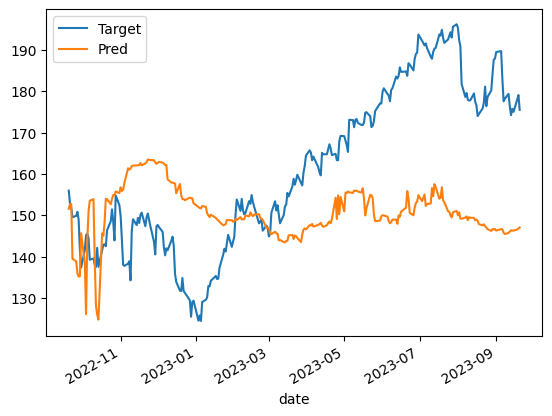

In [71]:
eval_df(y_test, pred_rf).plot()

# Deep Learning

## MLP

In [72]:
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import torch

In [73]:
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cpu'

In [74]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1682 entries, 2016-01-06 to 2022-09-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1682 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [75]:
mlflow.pytorch.autolog()

In [76]:
# convert to tensors

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.int64)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.int64)

In [77]:
# tensor To TensorDataset

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

In [95]:
# to DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [125]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.flatten = nn.Flatten()
        self.input_layer = nn.Linear(960, 480)
        self.hidden_layer1 = nn.Linear(480, 128)
        self.dropout_layer1 = nn.Dropout(0.2)
        self.hidden_layer2 = nn.Linear(128, 64)
        self.dropout_layer2 = nn.Dropout(0.2)
        self.hidden_layer3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        # self._stacked_model = nn.Sequential(
        #     nn.Linear(960, 480),
        #     nn.ReLU(),
        #     nn.Linear(480, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 1)
        # )
        
    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.input_layer(x))
        out = self.relu(self.hidden_layer1(out))
        out = self.dropout_layer1(out)
        out = self.relu(self.hidden_layer2(out))
        out = self.dropout_layer2(out)
        out = self.relu(self.hidden_layer3(out))
        out = self.output_layer(out)
        return out
        # pred = self._stacked_model(x)
        # return pred

In [126]:
model = MultiLayerPerceptron().to(device)

In [127]:
# model compile
learing_rate = 0.01
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

In [128]:
# set train loop
def train_loop(train_loader, model, loss_fn, optimizer):
    size = len(train_loader.dataset)

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.to(torch.float32), y.to(torch.float32))

        # Backpropagation
        optimizer.zero_grad()   # reset gradient
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        print(f'loss: {loss:>7f} [{current:>5d}/{size:5d}]')

In [129]:
# set test loop
def test_loop(test_loader, model, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():   # no gradient calculation
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:8f} \n')

In [130]:
# run model
epochs = 100

for i in range(epochs):
    print(f'Epoch {i+1}\n-------------------------------')
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)

print('Done!')

Epoch 1
-------------------------------
loss: 9848.121094 [    0/ 1682]
loss: 8546408.000000 [   10/ 1682]
loss: 18513.238281 [   20/ 1682]
loss: 1809.257080 [   30/ 1682]
loss: 20137.326172 [   40/ 1682]
loss: 8146.293945 [   50/ 1682]
loss: 16365.025391 [   60/ 1682]
loss: 7323.511719 [   70/ 1682]
loss: 10940.121094 [   80/ 1682]
loss: 3484.803955 [   90/ 1682]
loss: 4744.263184 [  100/ 1682]
loss: 10258.448242 [  110/ 1682]
loss: 6227.796875 [  120/ 1682]
loss: 3369.371094 [  130/ 1682]
loss: 3295.960938 [  140/ 1682]
loss: 1655.609619 [  150/ 1682]
loss: 1764.120361 [  160/ 1682]
loss: 170.157257 [  170/ 1682]
loss: 557.225952 [  180/ 1682]
loss: 694.328735 [  190/ 1682]
loss: 281.516418 [  200/ 1682]
loss: 2516.312988 [  210/ 1682]
loss: 387.305115 [  220/ 1682]
loss: 1105.297607 [  230/ 1682]
loss: 989.682983 [  240/ 1682]
loss: 1151.965454 [  250/ 1682]
loss: 1166.311523 [  260/ 1682]
loss: 474.161438 [  270/ 1682]
loss: 1065.322021 [  280/ 1682]
loss: 568.987915 [  290/ 1682]


In [131]:
model.eval()

MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Linear(in_features=960, out_features=480, bias=True)
  (hidden_layer1): Linear(in_features=480, out_features=128, bias=True)
  (dropout_layer1): Dropout(p=0.2, inplace=False)
  (hidden_layer2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer2): Dropout(p=0.2, inplace=False)
  (hidden_layer3): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [132]:
next(iter(test_dataloader))

[tensor([[3.1330e+00, 3.0677e+04, 1.2731e+02,  ..., 1.4300e-01, 9.9883e-01,
          9.0000e+00],
         [3.1750e+00, 3.1501e+04, 1.3189e+02,  ..., 1.4329e-01, 1.0022e+00,
          9.0000e+00],
         [3.2580e+00, 3.1438e+04, 1.3100e+02,  ..., 1.4274e-01, 1.0030e+00,
          9.0000e+00],
         ...,
         [2.8150e+00, 3.0968e+04, 1.2750e+02,  ..., 1.3990e-01, 9.6237e-01,
          9.0000e+00],
         [2.9510e+00, 3.1038e+04, 1.2860e+02,  ..., 1.3934e-01, 9.5962e-01,
          9.0000e+00],
         [3.0540e+00, 3.1385e+04, 1.3126e+02,  ..., 1.3891e-01, 9.7082e-01,
          9.0000e+00]]),
 tensor([[155],
         [152],
         [151],
         [149],
         [149],
         [150],
         [148],
         [141],
         [137],
         [141]])]

In [133]:
pred_mlp = model(X_test_torch).squeeze().detach().numpy()
pred_mlp

array([67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84488,
       67.84488, 67.84488, 67.84488, 67.84488, 67.84488, 67.84

In [134]:
X_test

array([[[3.13299990e+00, 3.06773594e+04, 1.27313385e+02, ...,
         1.49229228e-01, 1.05641246e+00, 6.00000000e+00],
        [3.17499995e+00, 3.15006797e+04, 1.31889236e+02, ...,
         1.49313897e-01, 1.05201149e+00, 6.00000000e+00],
        [3.25799990e+00, 3.14382598e+04, 1.30999741e+02, ...,
         1.49503648e-01, 1.05661333e+00, 6.00000000e+00],
        ...,
        [3.59500003e+00, 3.11350898e+04, 1.30930573e+02, ...,
         1.44423097e-01, 9.98203278e-01, 9.00000000e+00],
        [3.67400002e+00, 3.09618203e+04, 1.27916229e+02, ...,
         1.43657520e-01, 9.98402536e-01, 9.00000000e+00],
        [3.62599993e+00, 3.08224199e+04, 1.27204681e+02, ...,
         1.43000141e-01, 9.98831332e-01, 9.00000000e+00]],

       [[3.17499995e+00, 3.15006797e+04, 1.31889236e+02, ...,
         1.49313897e-01, 1.05201149e+00, 6.00000000e+00],
        [3.25799990e+00, 3.14382598e+04, 1.30999741e+02, ...,
         1.49503648e-01, 1.05661333e+00, 6.00000000e+00],
        [3.25999999e+00, 

<Axes: xlabel='date'>

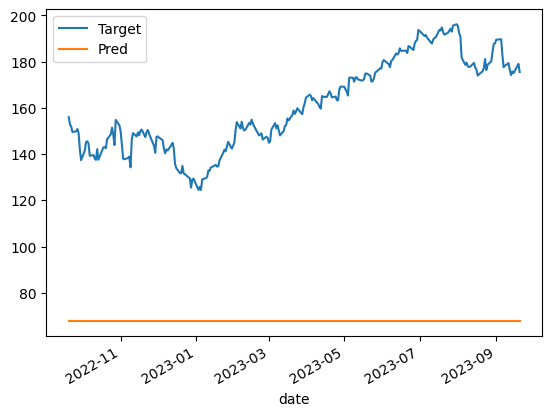

In [135]:
eval_df(y_test, pred_mlp).plot()

# Statistics model